In [1]:
import os
import csv
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator

METADATA_DIR = "Metadata"
MUTSUMMARY_DIR = "MutSummary"
PLOTS_DIR = "Output"

REFERENCE = 'EPI_ISL_402125'

In [12]:
plt.rcParams.update({'font.size': 30, 'font.weight': 'bold'})
fontsize = 30

In [3]:
background = pd.read_csv(os.path.join(METADATA_DIR, "SARS_CoV_2.csv"), index_col=0)
background = background[background['date'].str.len() == 10]

In [4]:
background['date'] = pd.to_datetime(background['date'], errors='coerce')
background = background.dropna()

background = background[background["host"] == "Human"]

# background['Compare'] = 'Global'
# background.loc[background['region'] == 'Europe', 'Compare'] = 'Europe'

In [5]:
animal = 'Human'

df = []

for folderName in os.listdir(os.path.join(MUTSUMMARY_DIR, animal)):
    mutBase = folderName.split('_')[2][-1]
#     mutName = folderName.split('_')[1]
    siteName = int(folderName.split('_')[2][1:-1])
    print(siteName)
    proteinName = folderName.split('_')[0]
    for fileName in os.listdir(os.path.join(MUTSUMMARY_DIR, animal, folderName)):
        if fileName.startswith(mutBase):
            if fileName.endswith('trans.csv'):
                filePath = os.path.join(MUTSUMMARY_DIR, animal, folderName, fileName)
                with open(filePath) as f:
                    ac = []
                    for row in f:
                        row = row.strip()
                        if row in background.index:
                            ac.append(row)
                    if len(ac):
                        hasMut = background.loc[ac].copy()
                        hasMut['Mut'] = folderName
                        hasMut['protein'] = proteinName
                        hasMut['Base'] = fileName[0]
                        hasMut['site'] = siteName
                        df.append(hasMut)
            elif fileName.endswith('trans_meta.csv'):
                filePath = os.path.join(MUTSUMMARY_DIR, animal, folderName, fileName)
                mutInfo = pd.read_csv(filePath, index_col=0)
                if len(mutInfo):
                    ac = []
                    for i in mutInfo.index:
                        if i in background.index:
                            ac.append(i)
                    hasMut = background.loc[ac].copy()
                    hasMut['Mut'] = folderName
                    hasMut['protein'] = proteinName
                    hasMut['Base'] = fileName[0]
                    hasMut['site'] = siteName
                    df.append(hasMut)

df = pd.concat(df)
df = df.sort_values("site")
# df[['Year', "Month", "Day"]] = df['date'].str.split('-', expand=True)
# df['Date_str'] = df['Date']
# df['Date'] = pd.to_datetime(df['date'], errors='coerce')
# df = df.dropna()
# df = df.sort_values('Date')
# df = df.reset_index(drop=True)

# df['Compare'] = 'Global'
# df.loc[df['Region'] == 'Europe', 'Compare'] = 'Europe'

# for ac, acInfo in df.groupby(df.index):
#     haplo = ', '.join(acInfo['Mut'])
#     df.loc[ac, 'Haplotype'] = haplo

15766
1163
3267
10323
11083
29402
28883
28975
28311
28869
28472
28881
28854
28977
28887
288887
25563
22227
23604
23664
23403
23012
23063
23604
22992
25088


In [6]:
E484K = df[df['Mut'] == "S_E484K_G23012A"].sort_values("date")

In [7]:
supp_muts = [folderName for folderName in os.listdir(os.path.join(MUTSUMMARY_DIR, 'Supp'))]

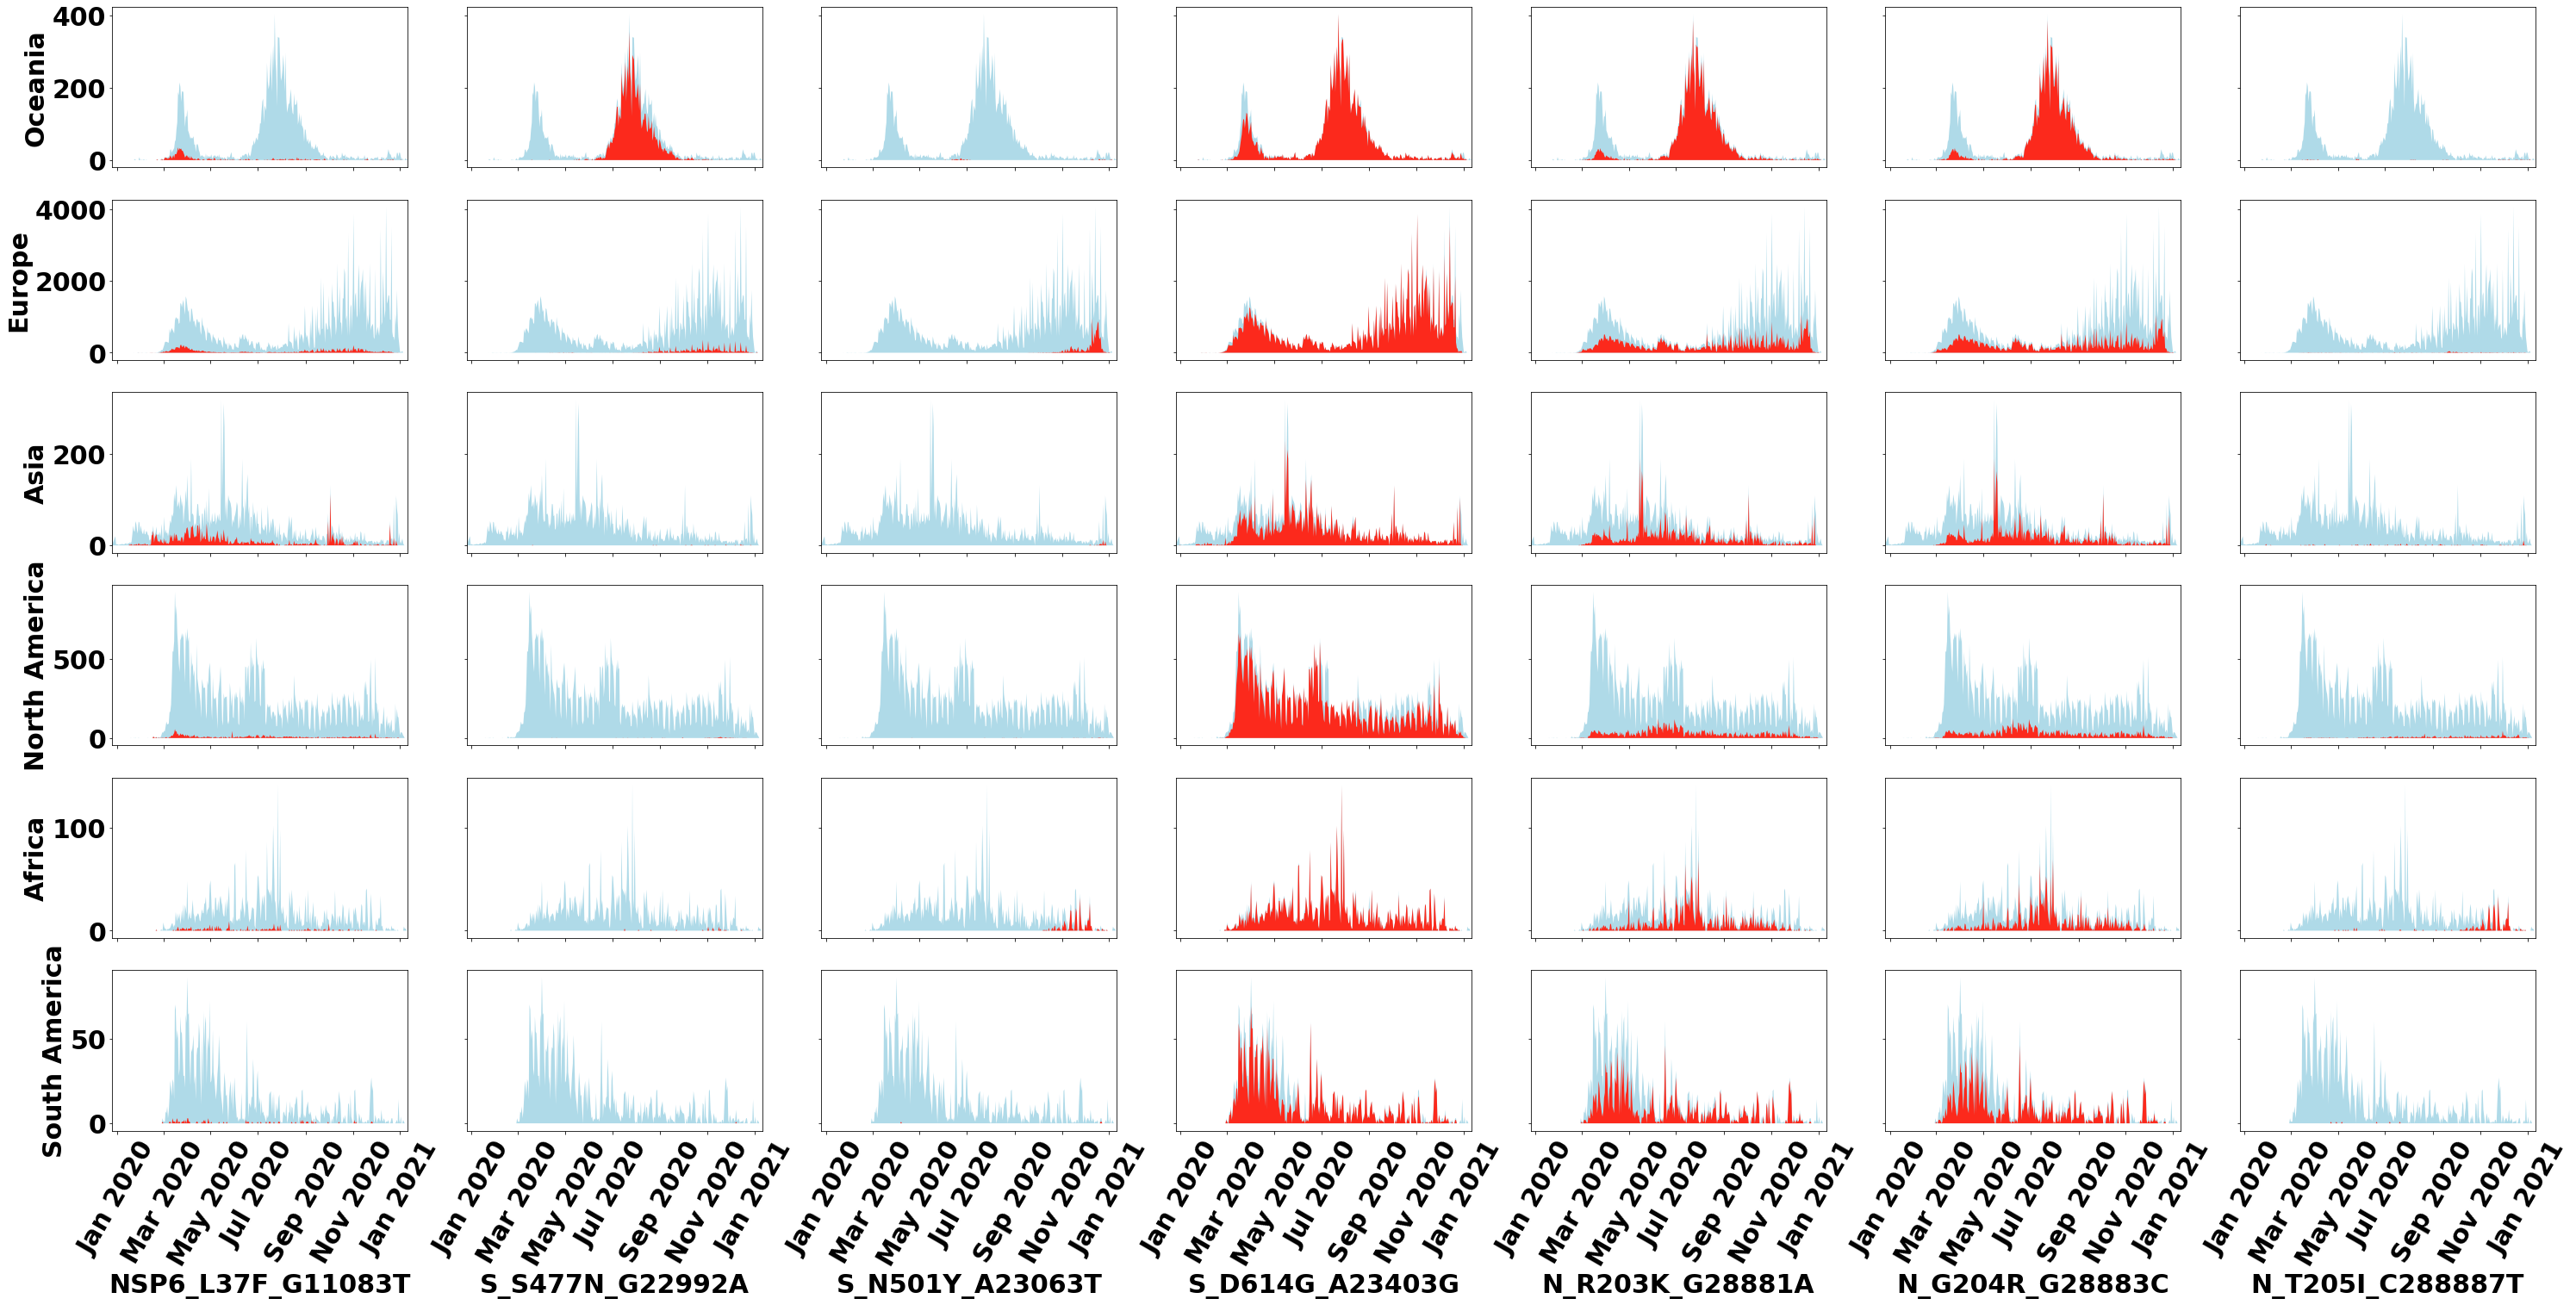

In [13]:
proteins = df['protein'].unique()
# colors = ["#65D640", '#1CA4FC', '#D12177', '#FD97CA', '#F7B92B', '#FC291C', '#000080', 'black']
# colors = dict(i for i in zip(proteins, colors))

regions = df["region_exposure"].unique()
# sites = [sInfo["Mut"].unique()[0] for s, sInfo in df[["Mut", "site"]].groupby("site")]
sites = []
for s, sInfo in df[["Mut", "site"]].groupby("site"):
    s = sInfo["Mut"].unique()[0]
    if s not in supp_muts:
        sites.append(s)

nregion = len(regions)
nsites = len(sites)

fig, axes = plt.subplots(
    nregion,
    nsites,
    sharex=True,
    sharey='row',
    figsize = (3 * nsites * 2.4, 24)
)

x_pos = background['date'].unique()
x_pos.sort()
x_pos = pd.to_datetime(x_pos)

for i in range(nsites):
    site = sites[i]
    proteinName = site.split('_')[0]
    siteInfo = df.loc[df['Mut'] == site]
    for j in range(nregion):
        region = regions[j]
        bg = background.loc[background['region_exposure'] == region, 'date'].value_counts()
        s = siteInfo.loc[siteInfo['region_exposure'] == region, 'date'].value_counts()
        nbg = []
        bgSum = 0
        ns = []
        nSum = 0
        nRatio = []
        for d in x_pos:
            if d in bg.index:
                bgNum = bg[d]
            else:
                bgNum = 0
            bgSum += bgNum
            nbg.append(bgNum)
#             nbg.append(bgSum)
            
            if d in s.index:
                sNum = s[d]
            else:
                sNum = 0
            nSum += sNum
            ns.append(sNum)
#             ns.append(nSum)
        ax = axes[j][i]
        ax.fill_between(x_pos, 0, nbg, label='total', facecolor='#AFDAE8')
        ax.fill_between(x_pos, 0, ns, label = proteinName, facecolor='#FC291C')
#         if region == "Asia":
#             ax.set_yscale('log', base=2)
        ax.tick_params(axis='x', labelrotation=60)
        ax.set_xlim([x_pos[1], x_pos[-1]])
        ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
        if j == nregion - 1:
            ax.set_xlabel(site, fontsize=fontsize, fontweight='bold')
        if i == 0:
            ax.set_ylabel(region, fontsize=fontsize, fontweight='bold')
#             if i == 0:
#                 axes[i][j].legend(loc='upper left')
                
plt.savefig(os.path.join(PLOTS_DIR, "sites.pdf"), bbox_inches="tight")
plt.show()

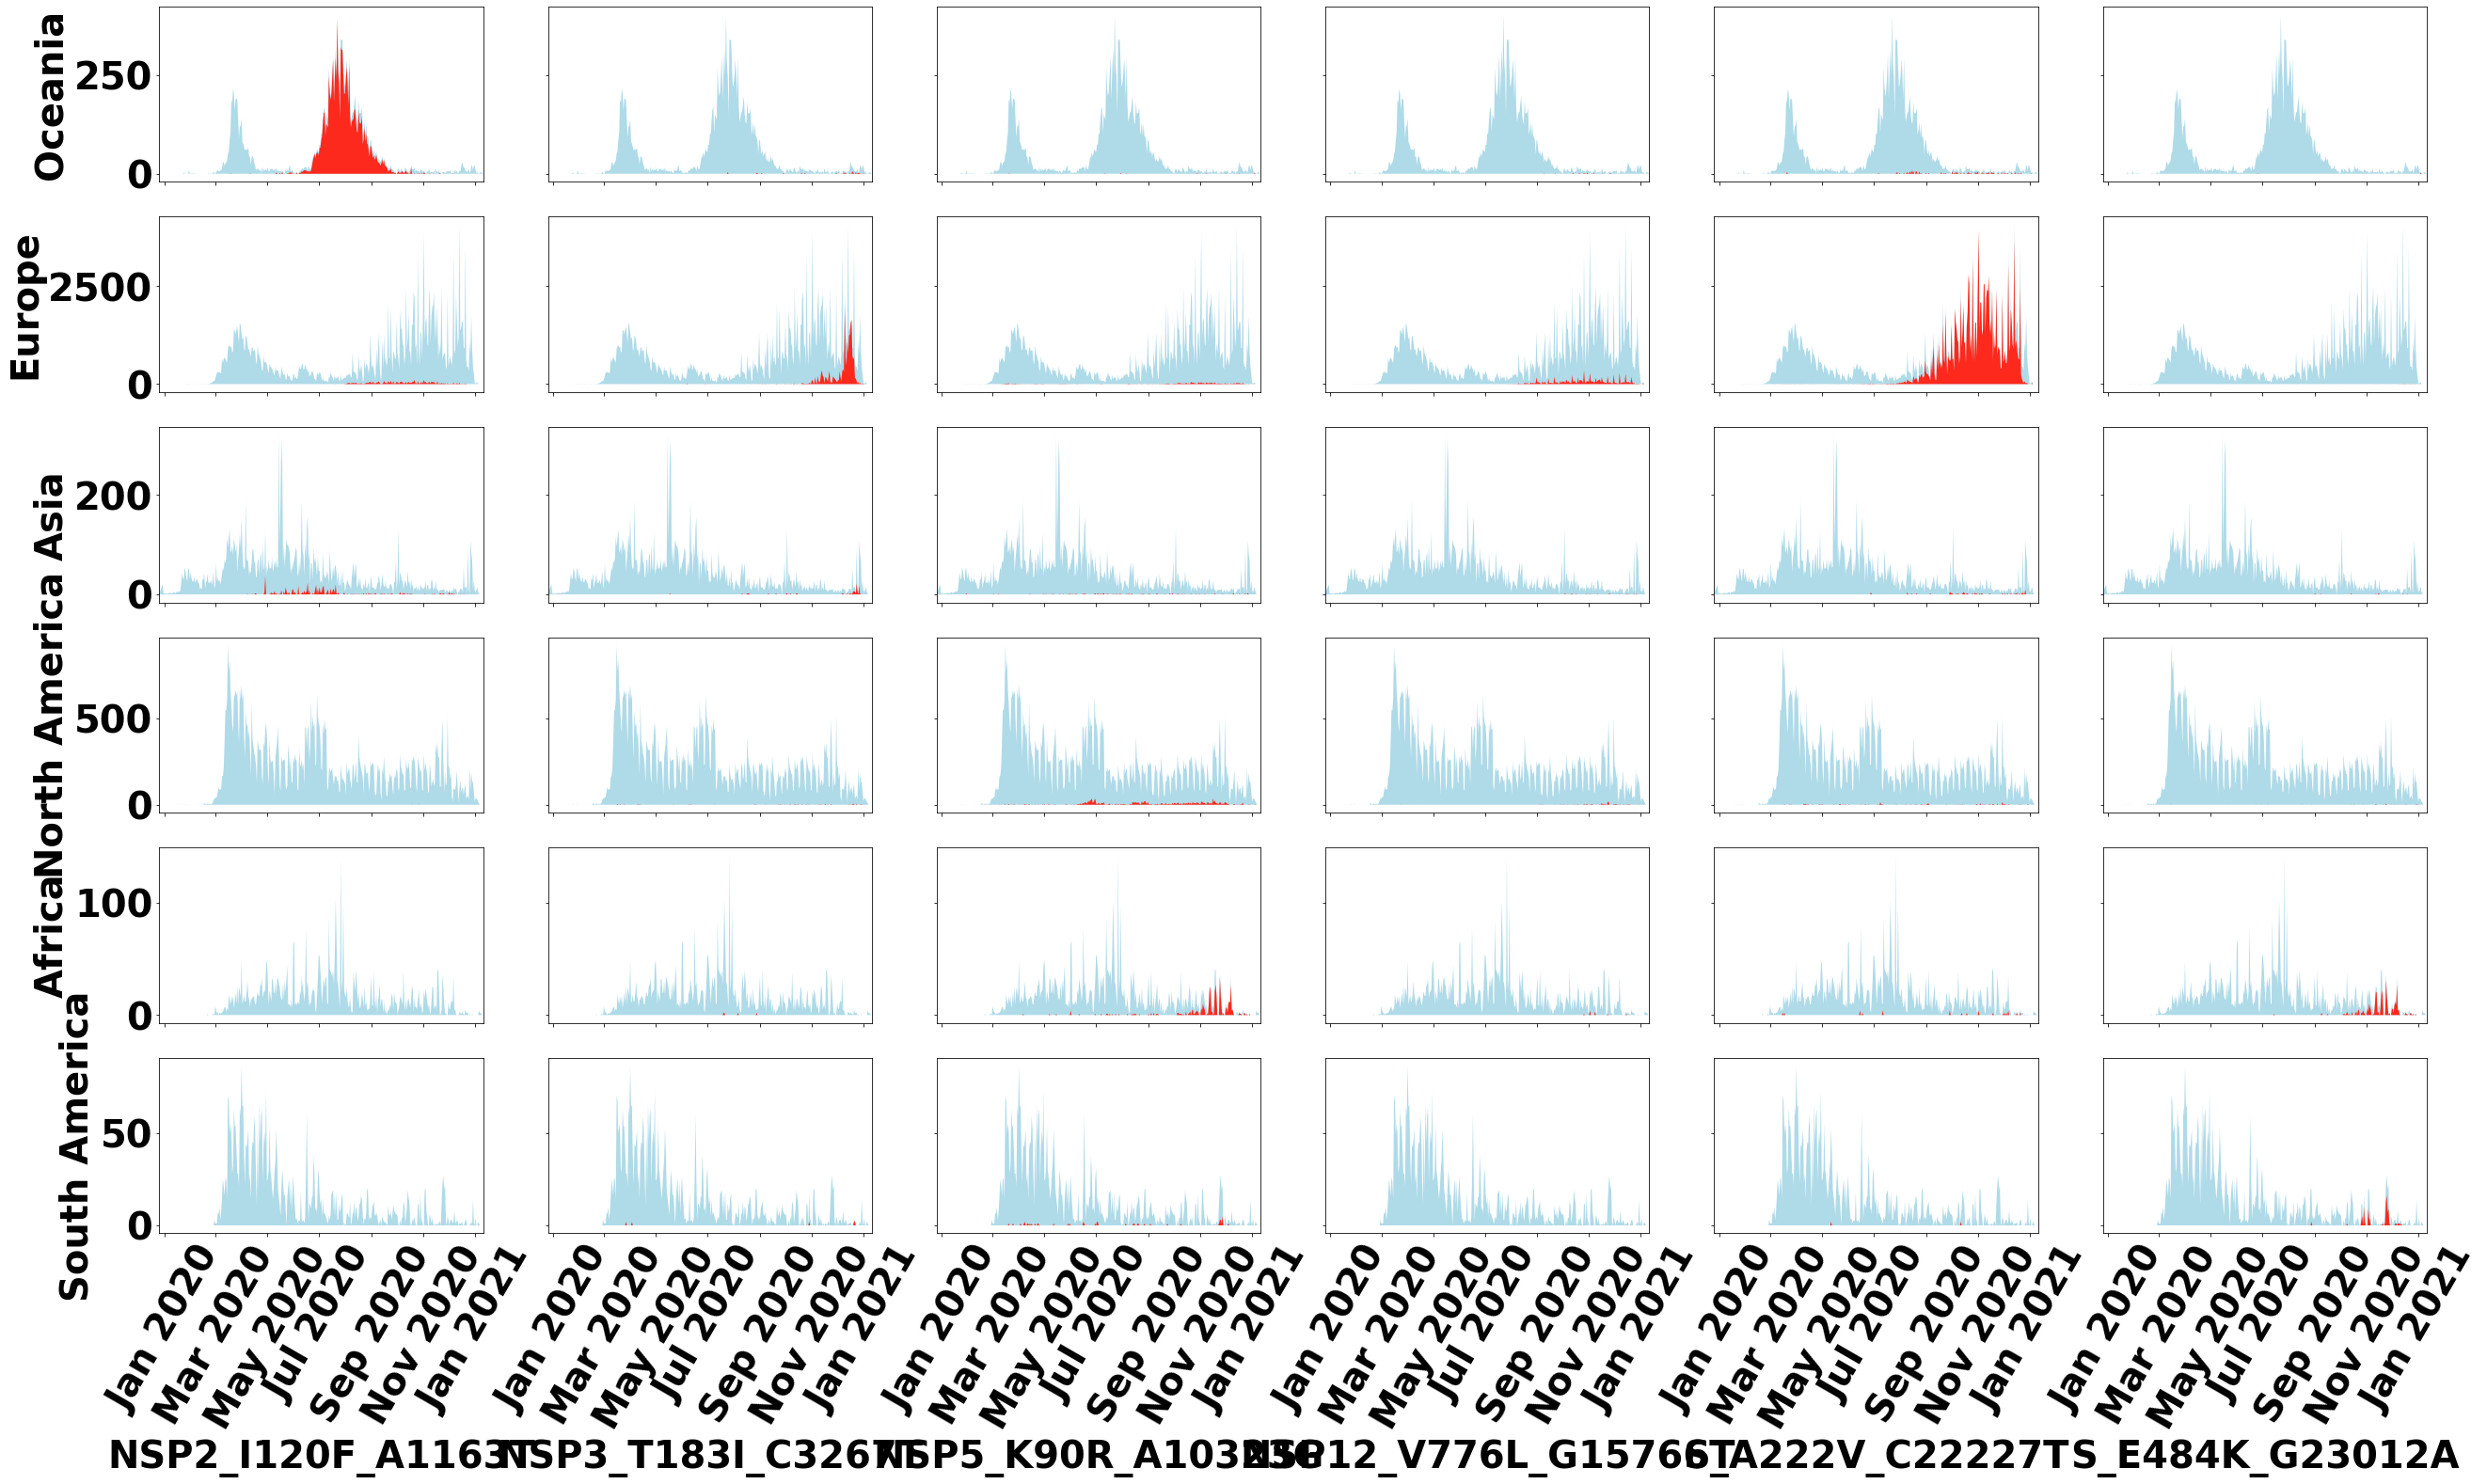

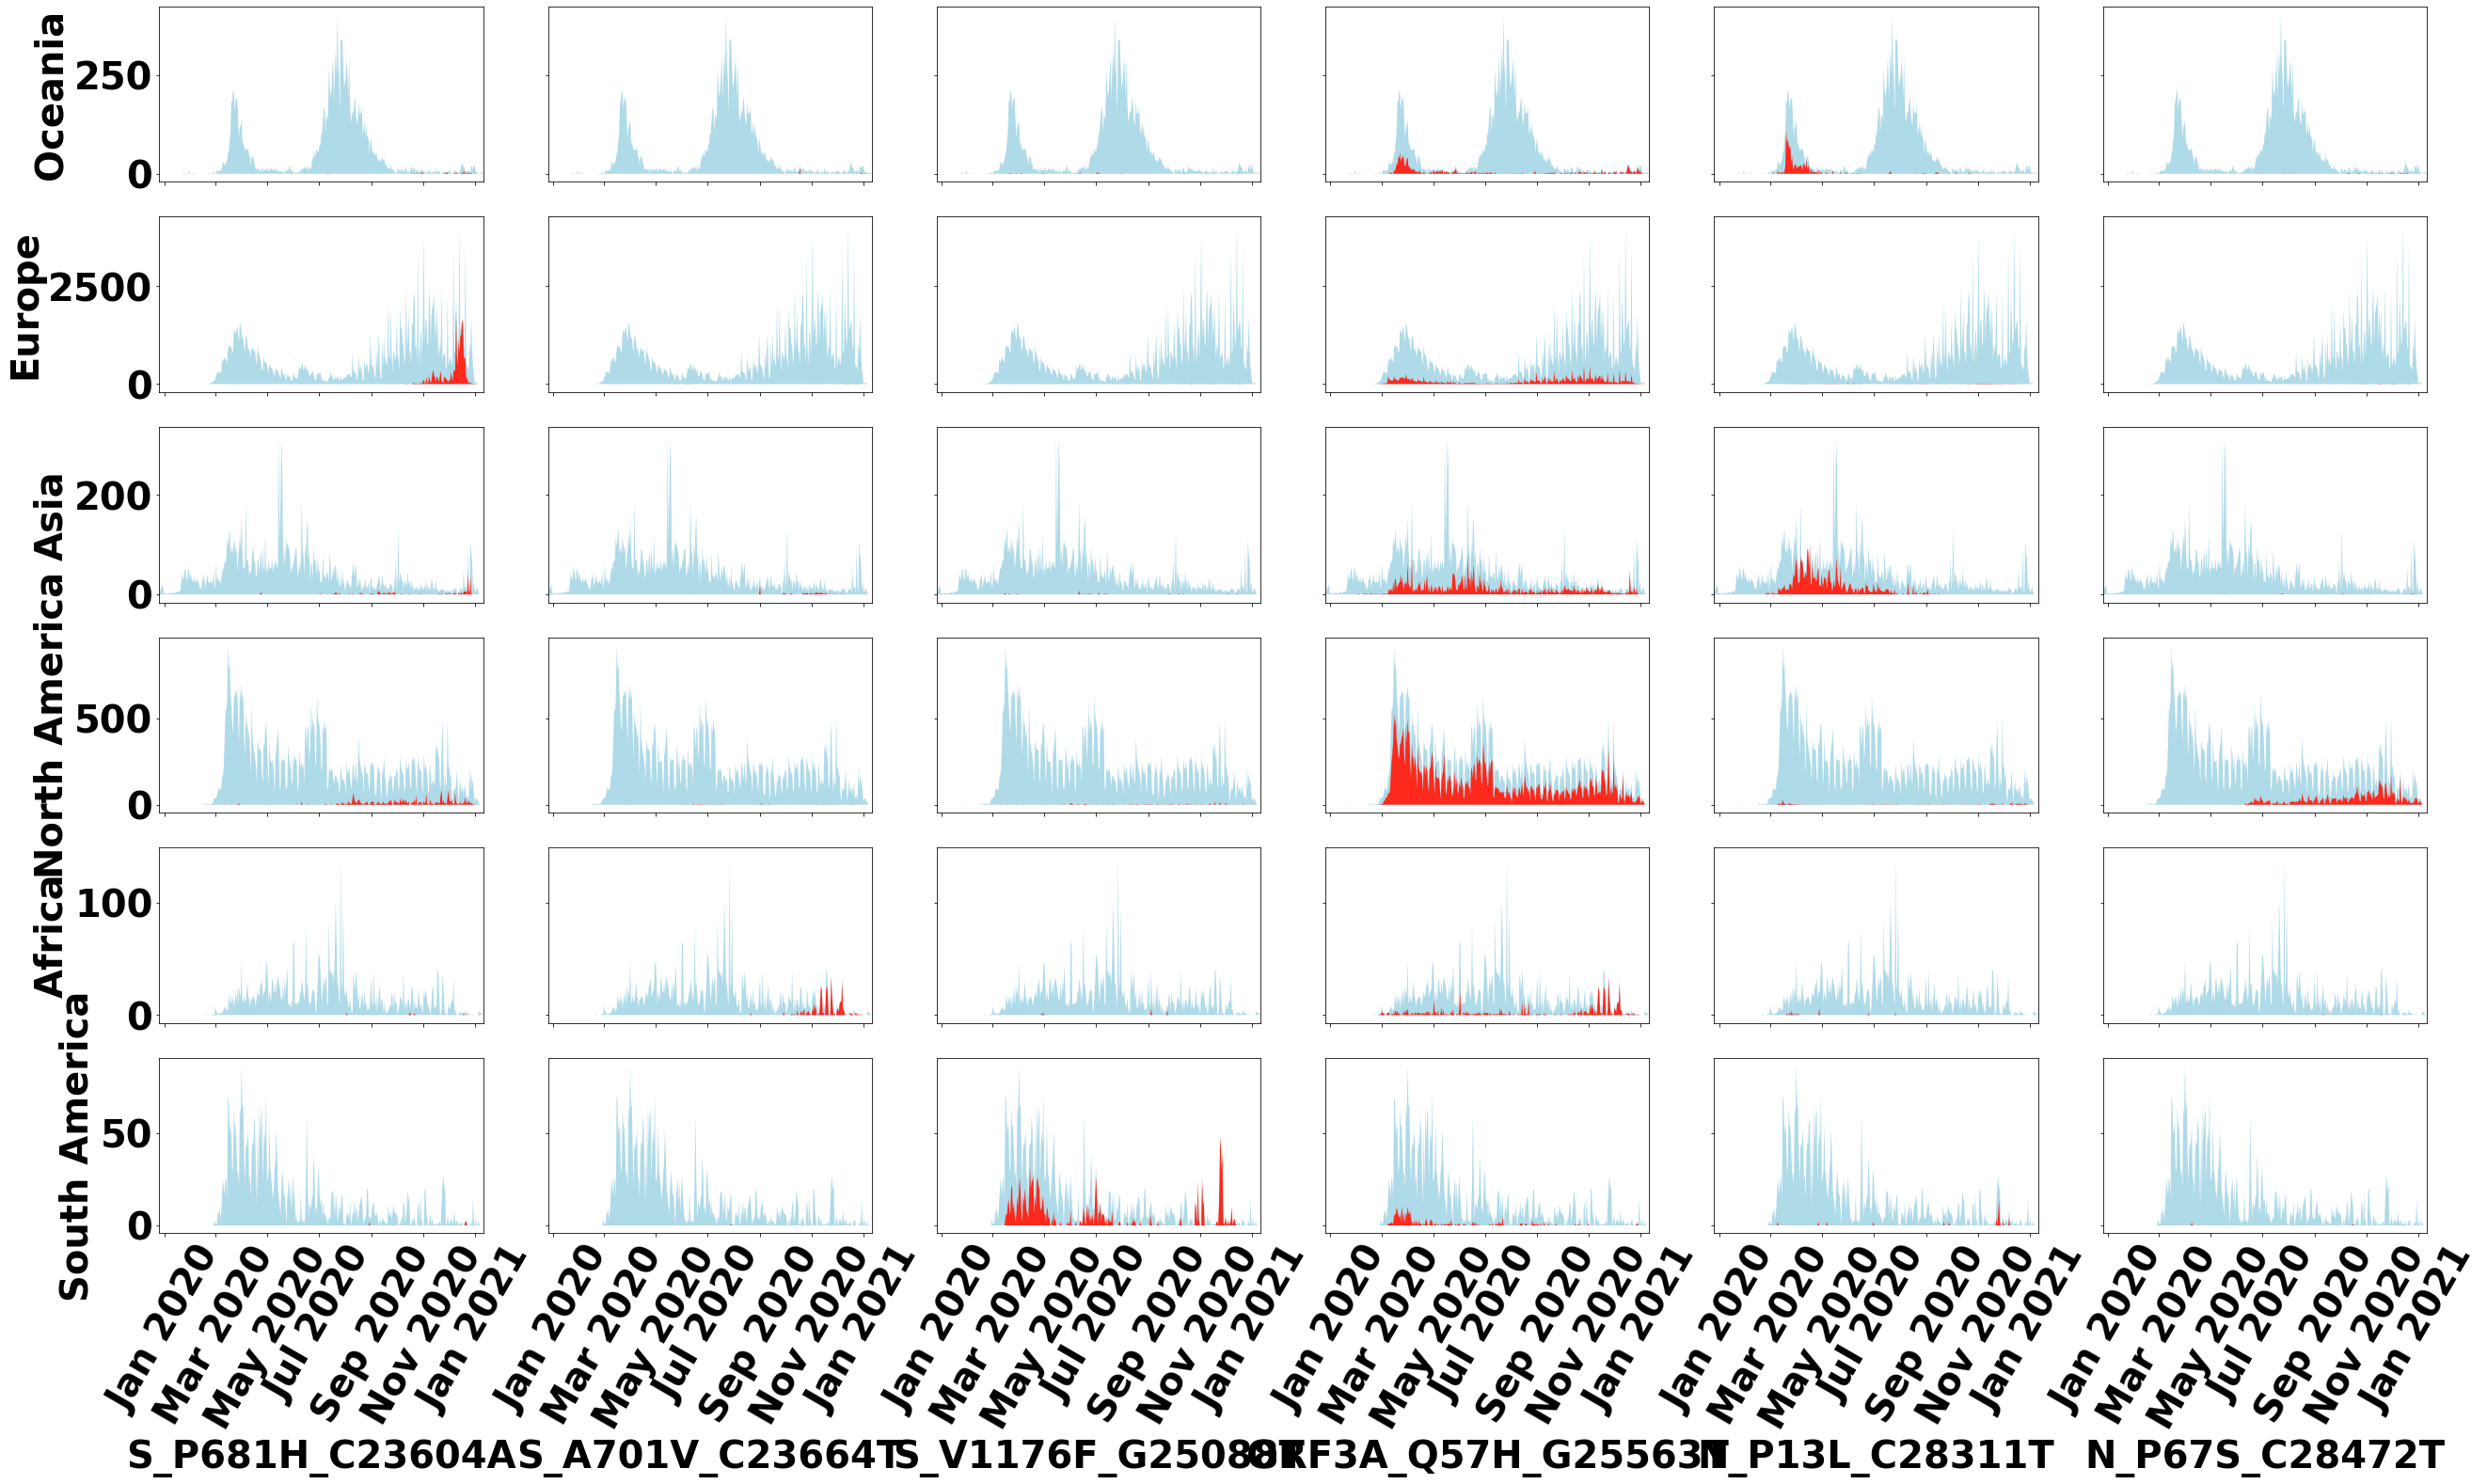

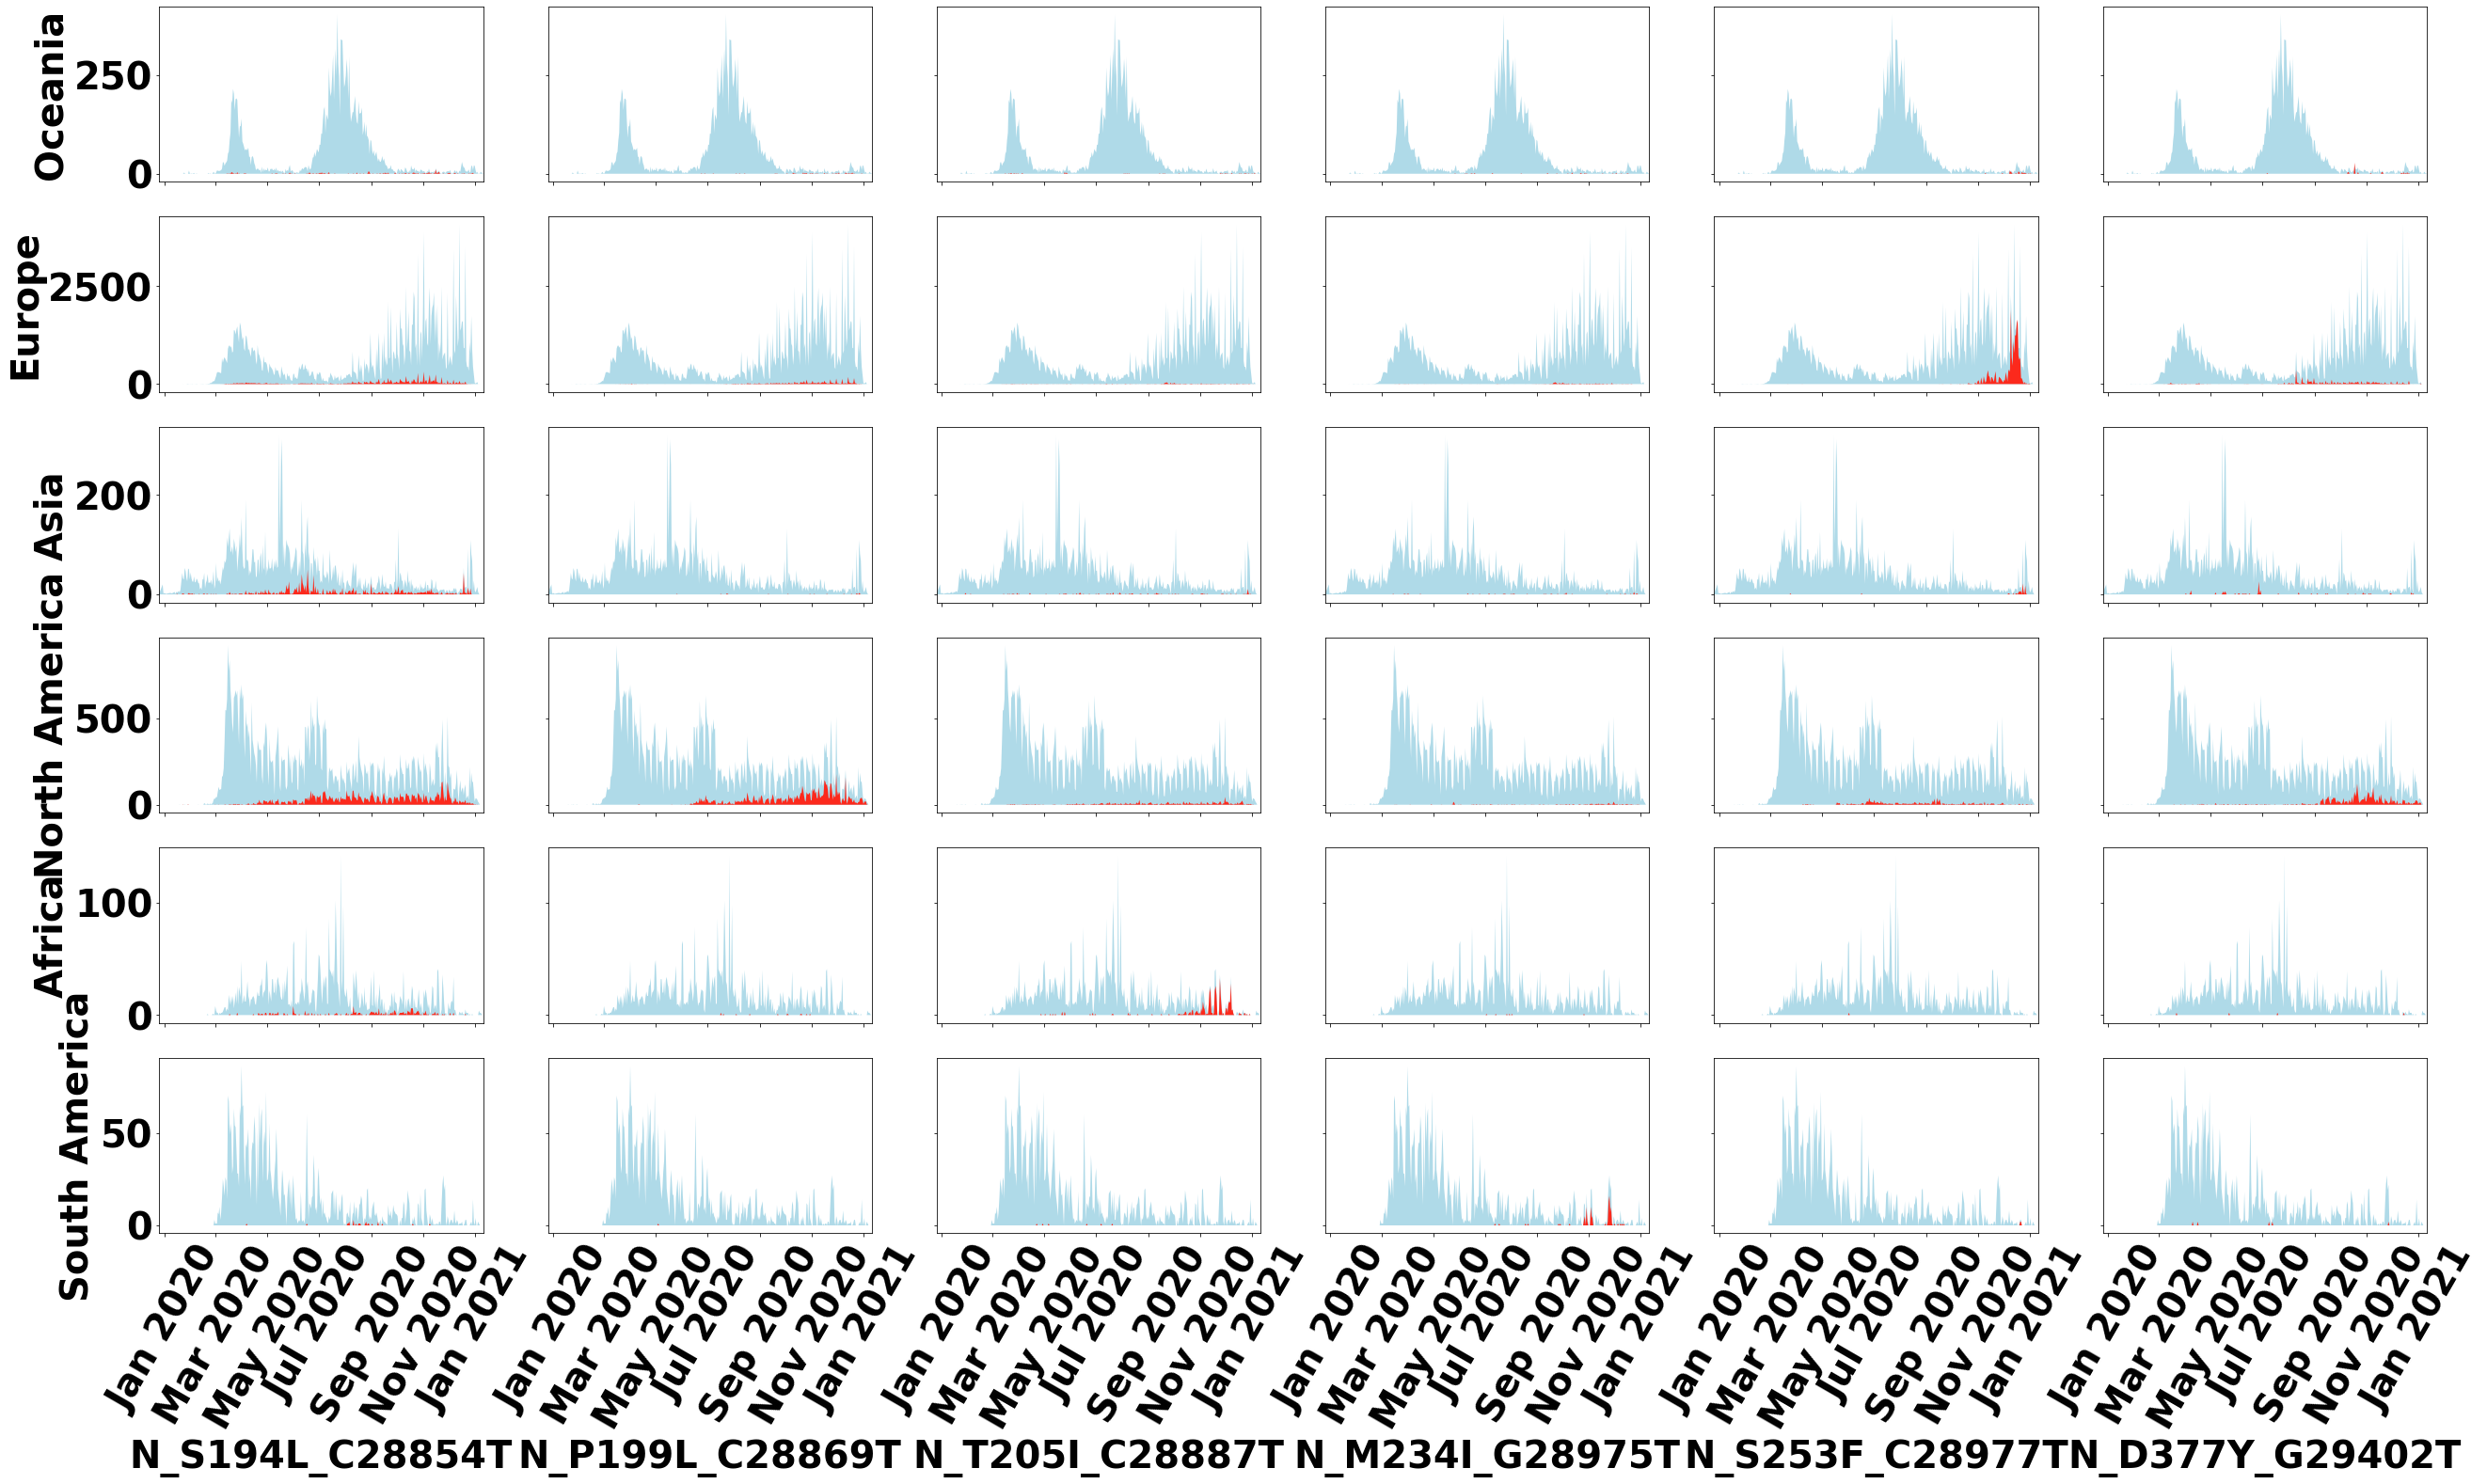

In [9]:
siteMapping = { int(mut.split('_')[-1][1:-1]): mut for mut in supp_muts }
allSites = list(siteMapping.keys())
allSites.sort()

df["plot_group"] = pd.NA


plot_group = 0
n = 0
columnPerPlot = 6

for site in allSites:
    n += 1
    df.loc[df["Mut"] == siteMapping[site], "plot_group"] = plot_group
    if n == columnPerPlot:
        n = 0
        plot_group += 1

color = '#FC291C'
regions = df["region_exposure"].unique()
nregion = len(regions)

for protein, proteinInfo in df.groupby('plot_group'):
    sites = [sInfo["Mut"].unique()[0] for s, sInfo in proteinInfo[["Mut", "site"]].groupby("site")]
    nsites = columnPerPlot
    fig, axes = plt.subplots(
        nregion,
        nsites,
        sharex=True,
        sharey='row',
        figsize = (3 * nsites * 2.4, 24)
    )

    x_pos = background['date'].unique()
    x_pos.sort()
    x_pos = pd.to_datetime(x_pos)

    for i in range(nsites):
        site = sites[i]
        if site:
            proteinName = site.split('_')[0]
            siteInfo = proteinInfo.loc[proteinInfo['Mut'] == site]
            for j in range(nregion):
                region = regions[j]
                bg = background.loc[background['region_exposure'] == region, 'date'].value_counts()
                s = siteInfo.loc[siteInfo['region_exposure'] == region, 'date'].value_counts()
                nbg = []
                bgSum = 0
                ns = []
                nSum = 0
                nRatio = []
                for d in x_pos:
                    if d in bg.index:
                        bgNum = bg[d]
                    else:
                        bgNum = 0
                    bgSum += bgNum
                    nbg.append(bgNum)
        #             nbg.append(bgSum)

                    if d in s.index:
                        sNum = s[d]
                    else:
                        sNum = 0
                    nSum += sNum
                    ns.append(sNum)
                if nsites > 1:
                    ax = axes[j][i]
                else:
                    ax = axes[j]
#                ax.fill_between(x_pos, 0, nbg, alpha=0.2, label='total')
                ax.fill_between(x_pos, 0, nbg, label='total', facecolor='#AFDAE8')
                ax.fill_between(x_pos, 0, ns, label = proteinName, facecolor=color)
        #         ax.set_yscale('log', base=2)
                ax.tick_params(axis='x', labelrotation=60)
                ax.set_xlim([x_pos[1], x_pos[-1]])
                ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
                if j == nregion - 1:
                    ax.set_xlabel(site, fontsize=fontsize, fontweight='bold')
                if i == 0:
                    ax.set_ylabel(region, fontsize=fontsize, fontweight='bold')
        #             if i == 0:
        #                 axes[i][j].legend(loc='upper left')
    plt.savefig(os.path.join(PLOTS_DIR, str(protein) + ".pdf"), bbox_inches="tight")
    plt.show()

In [10]:
# protein_counts = defaultdict(int)

# for site in supp_muts:
#     protein = site.split('_')[0]
# #     if 'NSP' in protein:
# #         protein_counts['NSP'] += 1
# #     else:
#     protein_counts[protein] += 1

# nsites = max(protein_counts.values())

# color = '#FC291C'
# regions = df["region_exposure"].unique()
# nregion = len(regions)

# for protein, proteinInfo in df.groupby('protein'):
# #     sites = [sInfo["Mut"].unique()[0] for s, sInfo in proteinInfo[["Mut", "site"]].groupby("site")]
#     sites = [None for i in range(nsites)]
#     n = 0
#     for s, sInfo in proteinInfo[["Mut", "site"]].groupby("site"):
#         site = sInfo["Mut"].unique()[0]
#         if site in supp_muts and site.split('_')[0] == protein:
#             sites[n] = site
#             n += 1
#     print(sites, n)
#     if n:
#         fig, axes = plt.subplots(
#             nregion,
#             nsites,
#             sharex=True,
#             sharey='row',
#             figsize = (3 * nsites, 10)
#         )

#         x_pos = background['date'].unique()
#         x_pos.sort()
#         x_pos = pd.to_datetime(x_pos)

#         for i in range(nsites):
#             site = sites[i]
#             if site:
#                 proteinName = site.split('_')[0]
#                 siteInfo = proteinInfo.loc[proteinInfo['Mut'] == site]
#                 for j in range(nregion):
#                     region = regions[j]
#                     bg = background.loc[background['region_exposure'] == region, 'date'].value_counts()
#                     s = siteInfo.loc[siteInfo['region_exposure'] == region, 'date'].value_counts()
#                     nbg = []
#                     bgSum = 0
#                     ns = []
#                     nSum = 0
#                     nRatio = []
#                     for d in x_pos:
#                         if d in bg.index:
#                             bgNum = bg[d]
#                         else:
#                             bgNum = 0
#                         bgSum += bgNum
#                         nbg.append(bgNum)
#             #             nbg.append(bgSum)

#                         if d in s.index:
#                             sNum = s[d]
#                         else:
#                             sNum = 0
#                         nSum += sNum
#                         ns.append(sNum)
#                     if nsites > 1:
#                         ax = axes[j][i]
#                     else:
#                         ax = axes[j]
# #                     ax.fill_between(x_pos, 0, nbg, alpha=0.2, label='total')
#                     ax.fill_between(x_pos, 0, nbg, label='total', facecolor='#AFDAE8')
#                     ax.fill_between(x_pos, 0, ns, label = proteinName, facecolor=color)
#             #         ax.set_yscale('log', base=2)
#                     ax.tick_params(axis='x', labelrotation=60)
#                     ax.set_xlim([x_pos[1], x_pos[-1]])
#                     ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
#                     if j == nregion - 1:
#                         ax.set_xlabel(site)
#                     if i == 0:
#                         ax.set_ylabel(region)
#             #             if i == 0:
#             #                 axes[i][j].legend(loc='upper left')
#             else:
#                 if nsites > 1:
#                     ax = axes[j][i]
#                     for row_axes in axes:
#                         row_axes[i].axis('off')
#                 else:
#                     for row_axes in axes:
#                         row_axes.axis('off')
#         plt.savefig(os.path.join(PLOTS_DIR, protein + ".pdf"), bbox_inches="tight")
#         plt.show()